# Vehicle Detection and Tracking Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob
import time
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Draw Boxes

In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """ This function takes an image `img`, a list of bounding boxes `bboxes`, 
         and optional color tuple `color` and line thickness `thick` as inputs
         then draws boxes in that color on the output and returns
         the resulting image
    """ 
    # Make a copy of the image
    im_copy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(im_copy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return im_copy

### Test on images

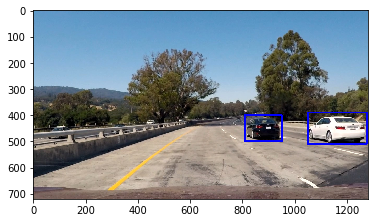

In [49]:
# Read-in an image
image = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)

# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((810, 400), (950, 500)), ((1050, 390), (1275, 510))]

# Plot result
result = draw_boxes(image, bboxes)
plt.imshow(result)

# Data Exploration

### Set the path for all car/non-car images

In [50]:
# Set the path for all car/non-car images
cars = glob.glob('./vehicles/**/*.png')
notcars = glob.glob('./non-vehicles/**/*.png')

### Auxiliary function to get characteristics of the data set (lecture notes)

In [51]:
def data_look(car_list, notcar_list):
    """ This function returns characteristics of the dataset
    """
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = cv2.cvtColor(cv2.imread(car_list[0]), cv2.COLOR_BGR2RGB)
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

### Test on data set

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


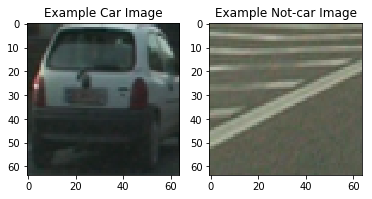

In [53]:
# Employ function to get characteristics of the dataset
data_info = data_look(cars, notcars)

# Print results
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Choose random car / not-car indices to plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = cv2.cvtColor(cv2.imread(cars[car_ind]), cv2.COLOR_BGR2RGB)
notcar_image = cv2.cvtColor(cv2.imread(notcars[notcar_ind]), cv2.COLOR_BGR2RGB)

# Plot results
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

## Histograms & Spatial Binning of Color

In [71]:
def bin_spatial(img, size=(32, 32)):
    """
    This function is used to compute binned color features
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256), vis=False):
    """
    This function is used to compute the color histogram features
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    if vis == True:
        # Generating bin centers
        # Generating bin centers
        bin_edges = channel1_hist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

        # Visualize
        fig, axs = plt.subplots(1,4, figsize=(16,3))
        axs[0].imshow(img)
        axs[1].bar(bin_centers, channel1_hist[0])
        axs[1].set_xlim(0, 256)
        axs[1].set_title('ColorHist_Ch1')
        axs[2].bar(bin_centers, channel2_hist[0])
        axs[2].set_xlim(0, 256)
        axs[2].set_title('ColorHist_Ch2')
        axs[3].bar(bin_centers, channel3_hist[0])
        axs[3].set_xlim(0, 256)
        axs[3].set_title('ColorHist_Ch3')
        
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Test Spatial Binning on images

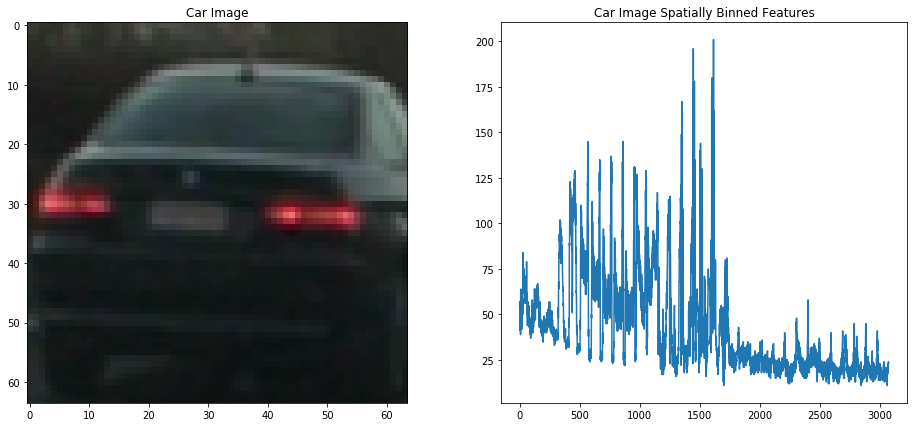

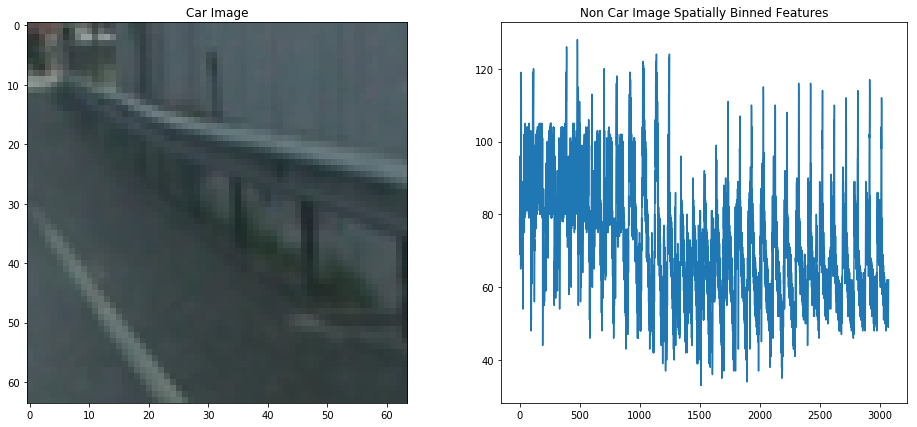

In [58]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))

# Read in car / not-car images
car_image = cv2.cvtColor(cv2.imread(cars[ind]), cv2.COLOR_BGR2RGB)
notcar_image = cv2.cvtColor(cv2.imread(notcars[ind]), cv2.COLOR_BGR2RGB)

# Apply spatial binning
car_feature_vec = bin_spatial(car_image)
noncar_feature_vec = bin_spatial(notcar_image)

# Plot features for car image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
ax1.imshow(car_image)
ax1.set_title('Car Image')
ax2.plot(car_feature_vec)
ax2.set_title('Car Image Spatially Binned Features')

# Plot features for non-car image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
ax1.imshow(notcar_image)
ax1.set_title('Car Image')
ax2.plot(noncar_feature_vec)
ax2.set_title('Non Car Image Spatially Binned Features')

### Test Color Histogram on images

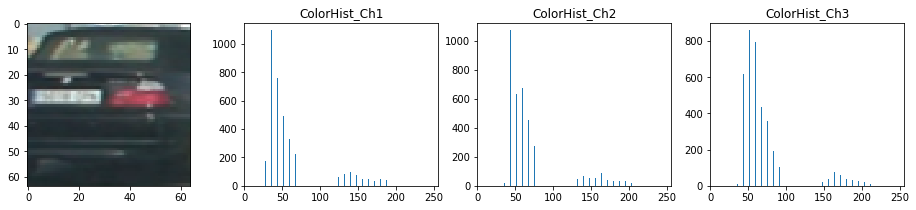

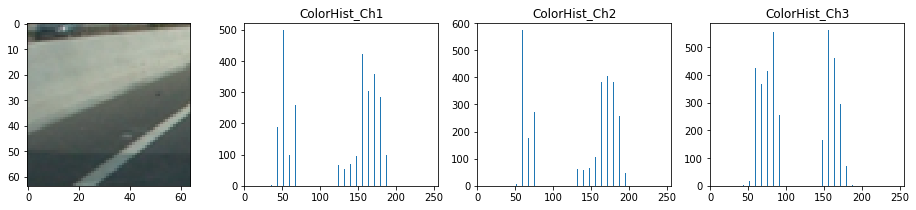

In [76]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))

# Read in car / not-car images
car_image = cv2.cvtColor(cv2.imread(cars[ind]), cv2.COLOR_BGR2RGB)
notcar_image = cv2.cvtColor(cv2.imread(notcars[ind]), cv2.COLOR_BGR2RGB)

# Apply color histogram
car_feature_vec = color_hist(car_image, nbins=32, bins_range=(0, 256), vis=True)
noncar_feature_vec = color_hist(notcar_image, nbins=32, bins_range=(0, 256), vis=True)

## Histogram of Oriented Gradients (HOG)

In [9]:
from skimage.feature import hog

### Function to get HOG features

In [10]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """ This function is used to extract Histogram of Oriented Gradients (HOG) for a given image `img` """
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=True, feature_vector=False, block_norm='L2-Hys')
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=False, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

### Test on car image

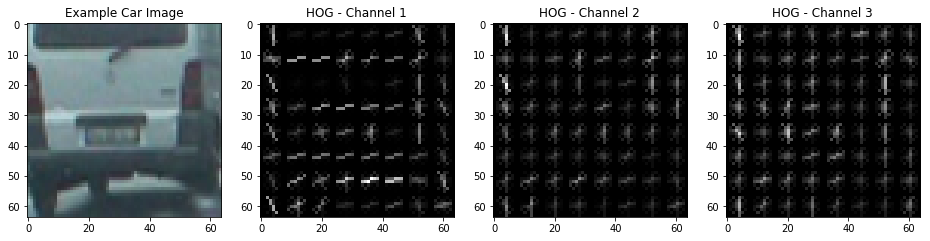

In [62]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))

# Read in the image
image = cv2.cvtColor(cv2.imread(cars[ind]), cv2.COLOR_BGR2RGB)
# Convert to grayscale
YUV = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image_ch1 = get_hog_features(YUV[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features, hog_image_ch2 = get_hog_features(YUV[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features, hog_image_ch3 = get_hog_features(YUV[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig, axs = plt.subplots(1,4, figsize=(16,16))
axs[0].imshow(image)
axs[0].set_title('Example Car Image')
axs[1].imshow(hog_image_ch1, cmap='gray')
axs[1].set_title('HOG - Channel 1')
axs[2].imshow(hog_image_ch2, cmap='gray')
axs[2].set_title('HOG - Channel 2')
axs[3].imshow(hog_image_ch3, cmap='gray')
axs[3].set_title('HOG - Channel 3')

### Test on non-car image

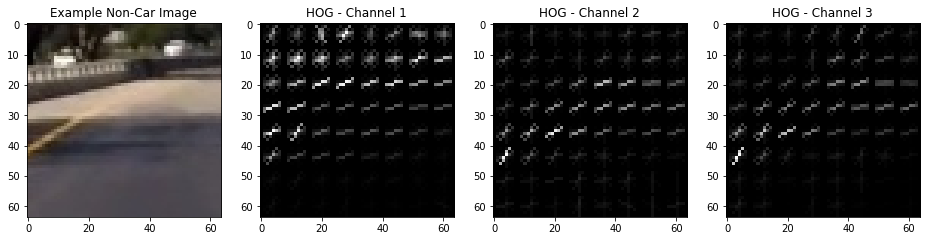

In [68]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(notcars))

# Read in the image
image = cv2.cvtColor(cv2.imread(notcars[ind]), cv2.COLOR_BGR2RGB)
# Convert to grayscale
YUV = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image_ch1 = get_hog_features(YUV[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features, hog_image_ch2 = get_hog_features(YUV[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features, hog_image_ch3 = get_hog_features(YUV[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig, axs = plt.subplots(1,4, figsize=(16,16))
axs[0].imshow(image)
axs[0].set_title('Example Non-Car Image')
axs[1].imshow(hog_image_ch1, cmap='gray')
axs[1].set_title('HOG - Channel 1')
axs[2].imshow(hog_image_ch2, cmap='gray')
axs[2].set_title('HOG - Channel 2')
axs[3].imshow(hog_image_ch3, cmap='gray')
axs[3].set_title('HOG - Channel 3')

## Extract HOG and Color Features

### Function to extract HOG/Spatial/Histogram features

In [12]:
def extract_features(imgs, color_space='RGB', spatial_size=(16, 16),
                        hist_bins=32, orient=16, 
                        pix_per_cell=6, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """ This function extracts features from a list of images `imgs` """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read-in an image
        image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        # Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            # Apply bin_spatial()
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [80]:
# Feature parameters
color_space = 'YUV'      # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 13              # HOG orientations
pix_per_cell = 16        # HOG pixels per cell
cell_per_block = 2       # HOG cells per block
hog_channel = 'ALL'      # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 32           # Number of histogram bins
spatial_feat = True      # Spatial features On or Off
hist_feat = True         # Histogram features On or Off
hog_feat = True          # HOG features On or Off

In [14]:
t=time.time()
# Extract car features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
# Extract non-car features
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

135.93 Seconds to extract HOG features...


### Build a Classifier

In [77]:
from sklearn import svm, grid_search
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from skimage.feature import hog

### Prepare training and testing datasets

In [16]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 13 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2268


### Train a linear SVM

In [19]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

5.86 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  1.  0.]
0.00286 Seconds to predict 10 labels with SVC


# Sliding Window Search

### Auxiliary function to perform color transformarion

In [20]:
def convert_color(img, color_space='RGB'):
    """ This function is used to convert the colorspace of an image
    """
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    # Return the color altered image
    return feature_image

### Function to perform Hog Sub-sampling Window Search

In [81]:
def find_cars(img, svc, scaler, spatial_size, hist_bins, orient, pix_per_cell, 
              cell_per_block, x_start, y_start_stop, scale):
    """ This function extracts features using hog sub-sampling and returns predicted 
    rectangles and draws them on an image `img`
    """
    # Define empty rectangle list
    rectangles = []
    # Define image to draw rectangles
    draw_img = np.copy(img)    
    # Define image to search
    ystart, ystop = y_start_stop
    img_tosearch = img[ystart:ystop,x_start:img.shape[1],:]
    ctrans_tosearch = convert_color(img_tosearch, color_space='YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))      
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left+x_start, ytop_draw+ystart),(xbox_left+win_draw+x_start,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append(((xbox_left+x_start, ytop_draw+ystart),(xbox_left+win_draw+x_start,ytop_draw+win_draw+ystart)))
                
    return draw_img, rectangles

### Test on images

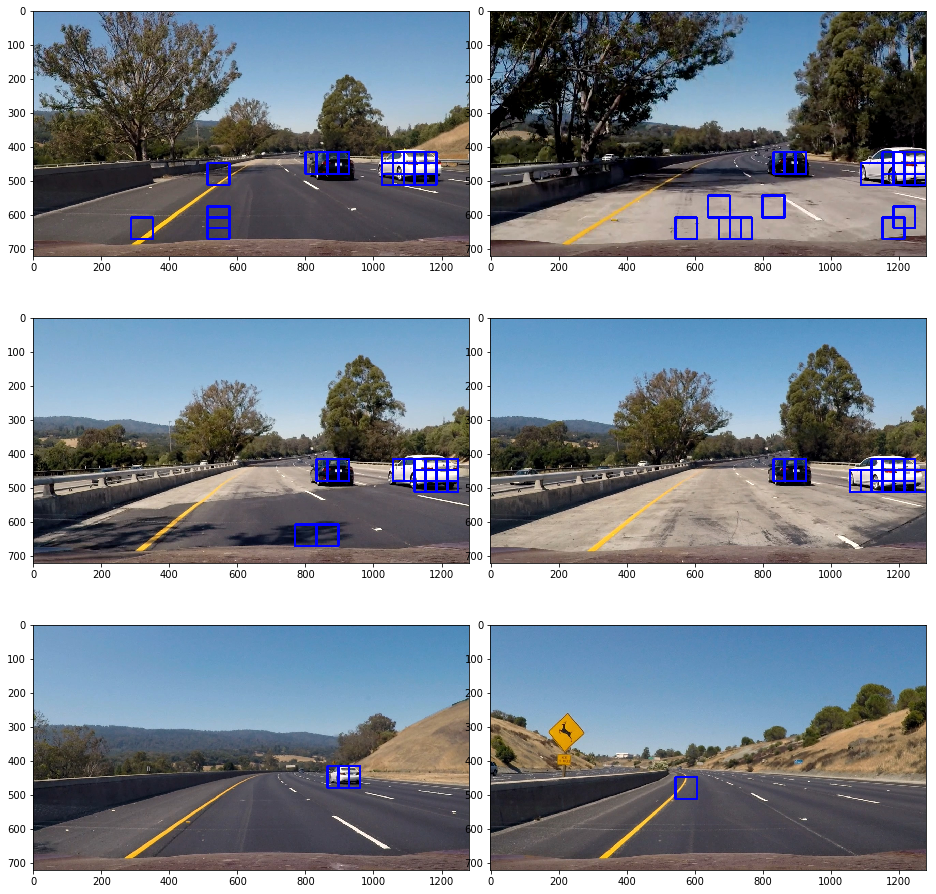

In [88]:
# Define search area
x_start = 0
y_start_stop = [414, 670]
# Define scaling 
scale = 1.0

# Read-in test images
images = glob.glob('./test_images/*.jpg')
    
# Set up plot
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.05)
axs = axs.ravel()

i = 0
for image in images:
    # Read-in and image
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    # Find cars
    out_img, rectangles = find_cars(img, svc, X_scaler, spatial_size, hist_bins, orient, 
                                    pix_per_cell, cell_per_block, x_start, y_start_stop, scale)
    # Plot results
    axs[i].imshow(out_img)
    i += 1

## Multiple scale window search 

In [90]:
# Lists of scalings and search areas 
scales = [1.0, 1.0, 1.5, 1.5, 2.0, 2.0, 2.5, 2.5, 3.0, 3.0]

x_start_list = [450, 450 , #  for scale 1.0
                450, 450 , #  for scale 1.5
                250, 250 , #  for scale 2.0
                250, 250 , #  for scale 2.5
                150, 150]  #  for scale 3.0

y_start_stop_list = [[414, 478], [446, 510], #  for scale 1.0
                     [398, 494], [446, 542], #  for scale 1.5
                     [414, 542], [478, 606], #  for scale 2.0
                     [385, 545], [465, 625], #  for scale 2.5
                     [372, 564], [468, 660]] #  for scale 3.0

In [93]:
def find_cars_multiscale(img, x_start_list, y_start_stop_list, scales, svc, X_scaler, 
                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    """ This function uses `find_cars()` in multi-scale windows, returns predicted 
    rectangles and draws them on an image `img`
    """
    # Copy the input image to draw rectangles on
    draw_img = np.copy(img)
    
    # Create empty list to append rectangles
    rectangles_list = []
    
    # Iterate through the 'scaling' and 'search area' lists
    for scale, x_start, y_start_stop in zip(scales, x_start_list, y_start_stop_list):
        # Find cars
        out_img, rectangles = find_cars(img, svc, X_scaler, spatial_size, hist_bins, orient, 
                                    pix_per_cell, cell_per_block, x_start, y_start_stop, scale)        
        # Append rectangles to list
        rectangles_list.append(rectangles)
        
    rectangles_out = [item for sublist in rectangles_list for item in sublist] 
    
    # Draw boxes on image
    out_img = draw_boxes(draw_img, rectangles_out)
    
    # Return resulting image and rectangles
    return out_img, rectangles_out

### Test on images

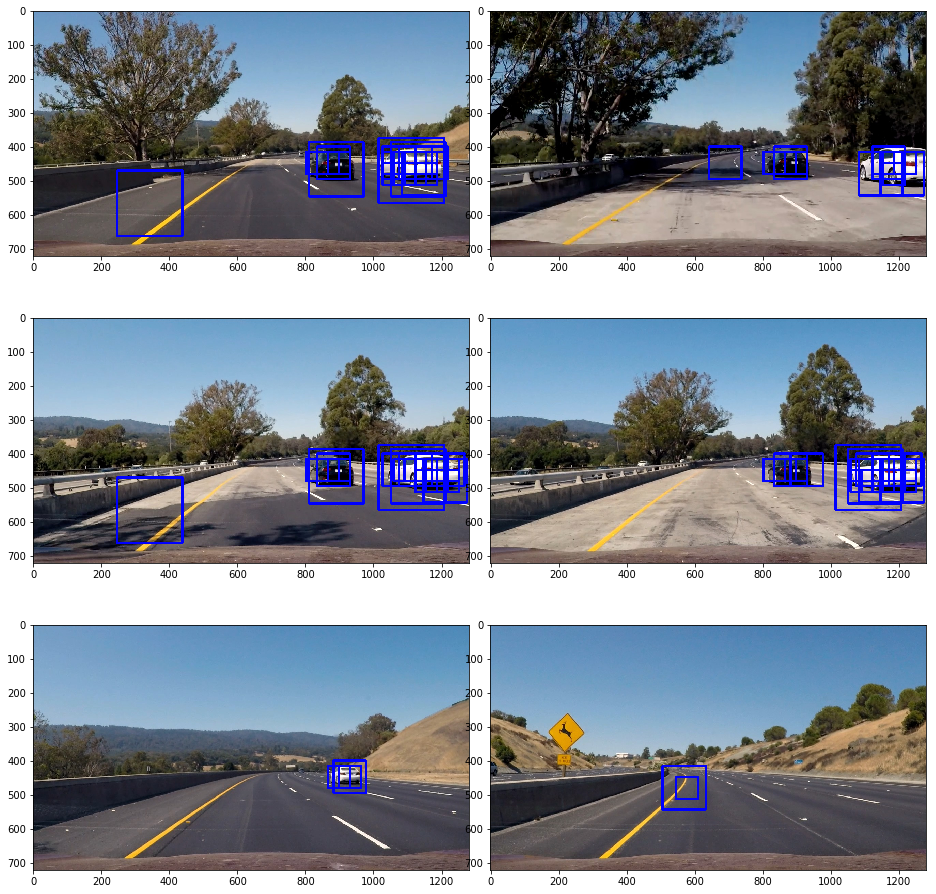

In [94]:
# Read in test images
images = glob.glob('./test_images/*.jpg')
    
# Set up plot
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.05)
axs = axs.ravel()

i = 0
for image in images:
    # Read-in image
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    # Find cars
    out_img, rectangles = find_cars_multiscale(img, x_start_list, y_start_stop_list, scales, svc, X_scaler, 
                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # Plot results
    axs[i].imshow(out_img)
    i += 1

## Filter Multiple Detections & False Positives

In [28]:
from scipy.ndimage.measurements import label

### Functions to filter Multiple Detections & False Positives

In [29]:
def add_heat(heatmap, bbox_list):
    """ This function adds "heat" to a map for a list of bounding boxes 
    """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [30]:
def apply_threshold(heatmap, threshold):
    """ This function thresholds the heatmap
    """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [31]:
def draw_labeled_bboxes(img, labels):
    """ This function is used to draw boxes aroung the labeled regions
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [32]:
def remove_false_boxes(in_img, out_img, bbox_list, threshold):
    """ This function employs `add_heat()`, `apply_threshold()` and `draw_labeled_bboxes()`
    to remove multiple detections and false positives
    """
    # Heatmap
    heatmap_img = np.zeros_like(out_img[:,:,0])    
    heatmap_img = add_heat(heatmap_img, bbox_list)
    # Thresholded Heat Map
    thres_heatmap_img = apply_threshold(np.copy(heatmap_img), threshold)
    # ScipY Labels
    labels = label(thres_heatmap_img)
    # Draw Labeled Boxes
    labeled_boxes_img = draw_labeled_bboxes(np.copy(in_img), labels)
    # Return all images
    return heatmap_img, thres_heatmap_img, labels, labeled_boxes_img

### Test on images

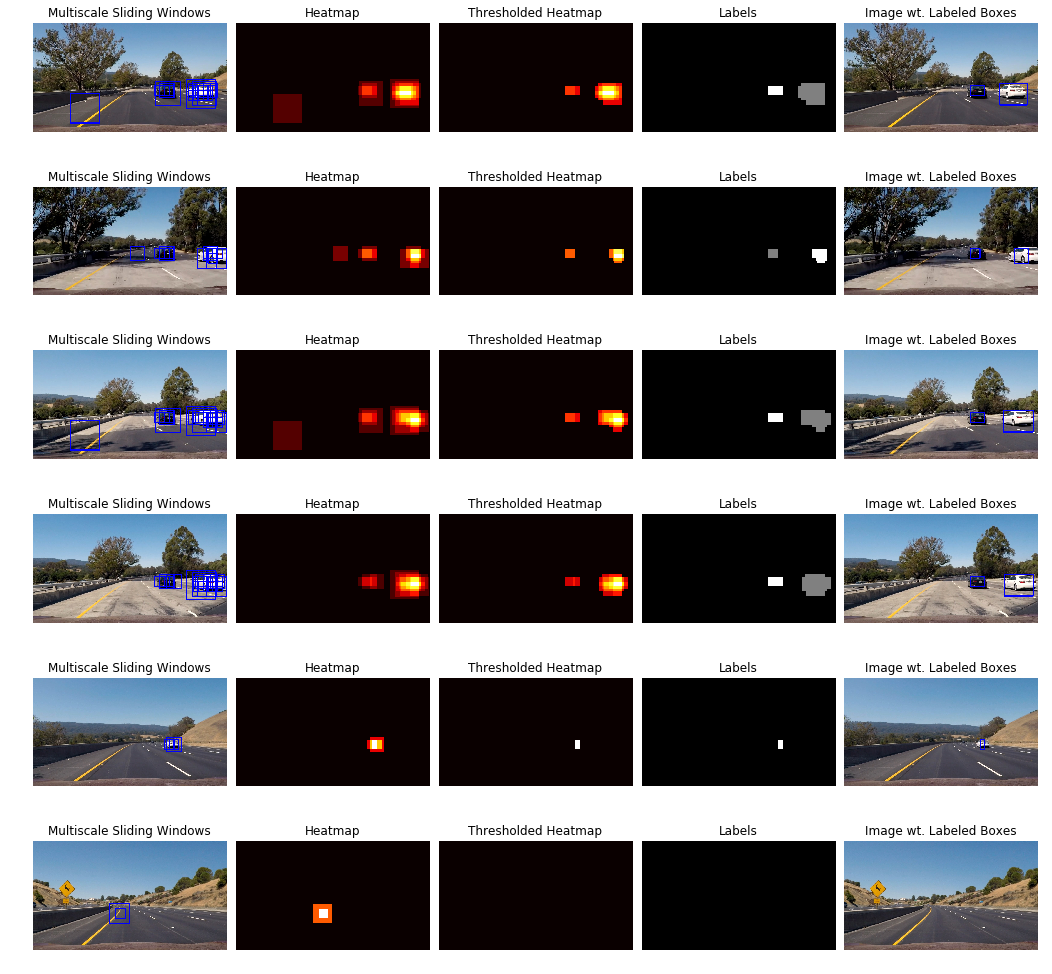

In [98]:
# Heatmap threshold
threshold = 2

# Read-in test images
images = glob.glob('./test_images/*.jpg')
    
# Set up plot
fig, axs = plt.subplots(len(images),5, figsize=(18, 18))
fig.subplots_adjust(hspace = .02, wspace=.05)
axs = axs.ravel()

i = 0
for image in images:
    # Read-in an image
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)    
    # Find cars 
    out_img, rectangles = find_cars_multiscale(img, x_start_list, y_start_stop_list, scales, svc, X_scaler, 
                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # Remove multiple detections and false positives
    heatmap_img, thres_heatmap_img, labels, labeled_boxes_img = remove_false_boxes(img, out_img, 
                                                                                   rectangles, threshold)
    # Plot results
    axs[i].imshow(out_img)
    axs[i].axis('off')
    axs[i].set_title('Multiscale Sliding Windows')
    i += 1
    axs[i].imshow(heatmap_img, cmap='hot')
    axs[i].axis('off')
    axs[i].set_title('Heatmap')
    i += 1
    axs[i].imshow(thres_heatmap_img, cmap='hot')
    axs[i].axis('off')
    axs[i].set_title('Thresholded Heatmap')
    i += 1
    axs[i].imshow(labels[0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title('Labels')
    i += 1
    axs[i].imshow(labeled_boxes_img)
    axs[i].axis('off')
    axs[i].set_title('Image wt. Labeled Boxes')
    i += 1

# Final Pipeline

In [99]:
def Final_Pipeline(img):
    """ This is the final pipeline """
    # Feature parameters
    color_space = 'YUV'      # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 13              # HOG orientations
    pix_per_cell = 16        # HOG pixels per cell
    cell_per_block = 2       # HOG cells per block
    hog_channel = 'ALL'      # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16)  # Spatial binning dimensions
    hist_bins = 32           # Number of histogram bins
    
    # Lists of scalings and search areas 
    scales = [1.0, 1.0, 1.5, 1.5, 2.0, 2.0, 2.5, 2.5, 3.0, 3.0]

    x_start_list = [450, 450 , #  for scale 1.0
                    450, 450 , #  for scale 1.5
                    250, 250 , #  for scale 2.0
                    250, 250 , #  for scale 2.5
                    150, 150]  #  for scale 3.0

    y_start_stop_list = [[414, 478], [446, 510], #  for scale 1.0
                         [398, 494], [446, 542], #  for scale 1.5
                         [414, 542], [478, 606], #  for scale 2.0
                         [385, 545], [465, 625], #  for scale 2.5
                         [372, 564], [468, 660]] #  for scale 3.0
    
    # Heatmap threshold
    threshold = 2

    # Find cars
    out_img, rectangles = find_cars_multiscale(img, x_start_list, y_start_stop_list, scales, svc, X_scaler, 
                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    # Remove multiple detections and false positives
    heatmap_img, thres_heatmap_img, labels, labeled_boxes_img = remove_false_boxes(img, out_img, 
                                                                                   rectangles, threshold)

    # Return resulting image
    return labeled_boxes_img

## Test Final Pipeline on images

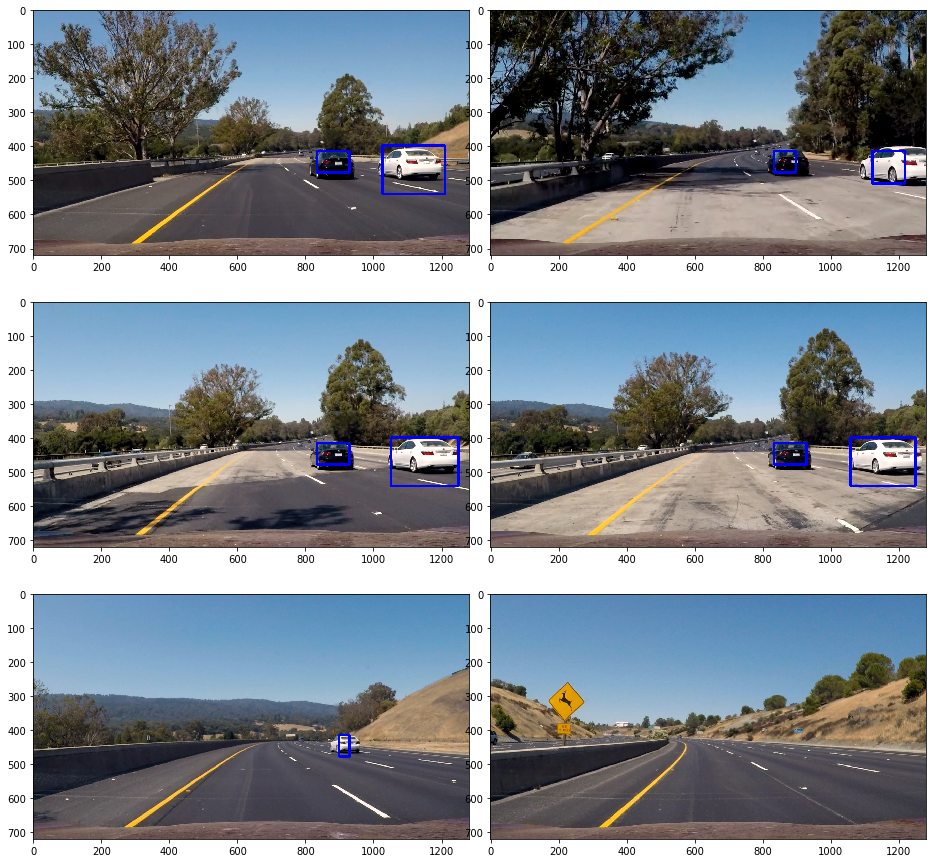

In [100]:
# Read-in test images
images = glob.glob('./test_images/*.jpg')
    
# Set up plot
fig, axs = plt.subplots(3,2, figsize=(16, 16))
fig.subplots_adjust(hspace = .02, wspace=.05)
axs = axs.ravel()

i = 0
for image in images:
    # Read-in an image
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)    
    # Run final pipeline on image
    labeled_boxes_img = Final_Pipeline(img)   
    # Plot results
    axs[i].imshow(labeled_boxes_img)
    i += 1

## Test Final Pipeline on video

In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [48]:
white_output = './output_video/project_video.mp4'
 
clip1 = VideoFileClip("./project_video.mp4")
# clip1 = VideoFileClip("./project_video.mp4").subclip(20,40)
# clip1 = VideoFileClip("./test_video.mp4")

white_clip = clip1.fl_image(Final_Pipeline) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_video/project_video.mp4
[MoviePy] Writing video ./output_video/project_video.mp4



 12%|█▏        | 152/1261 [01:40<11:19,  1.63it/s]


 24%|██▍       | 303/1261 [03:18<09:59,  1.60it/s]


 36%|███▌      | 454/1261 [04:58<09:00,  1.49it/s]


 48%|████▊     | 605/1261 [06:38<07:20,  1.49it/s]


 60%|█████▉    | 756/1261 [08:19<05:58,  1.41it/s]


 72%|███████▏  | 907/1261 [10:03<04:02,  1.46it/s]


 84%|████████▍ | 1057/1261 [11:52<02:10,  1.56it/s]


 96%|█████████▌| 1205/1261 [13:36<00:41,  1.34it/s]


100%|█████████▉| 1260/1261 [14:11<00:00,  1.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/project_video.mp4 

CPU times: user 13min 18s, sys: 18.4 s, total: 13min 36s
Wall time: 14min 13s
